***
# Part 1
***

In [1]:
# Import dataclass from the dataclasses module
from dataclasses import dataclass


# Define a data class to store Parameters
@dataclass
class Parameters:
    """
    Parameters for the overlapping generations model (OLG)
    """

    beta: float = 0.96**30  # Discount factor
    gamma: float = 5.0  # Relative risk aversion
    alpha: float = 0.36  # Capital share of output (production)
    delta: float = 1 - 0.94**30  # Capital depreciation
    z: float = 1.0  # Total factor productivity (TFP)
    tau: float = 0.0  # Payroll tax rate (Default is  0.0 --> No PAYGO system)


# Create an instance of the Parameters class
par = Parameters()

In [2]:
# Define a function to map k to factor prices r and w using the first-order conditions
def compute_prices(k, par: Parameters):
    """
    Return factor prices for a given capital-labor ratio and parameters.

    Parameters
    ----------
    k : float
        Capital-labor ratio.
    par : Parameters
        Instance of the Parameters class including model parameters for the OLG model.

    Returns
    -------
    r : float
        Return on capital after depreciation (interest rate)
    w : float
        Wage rate
    """
    # Return on capital after depreciation (interest rate)
    r = par.alpha * par.z * (k ** (par.alpha - 1)) - par.delta

    # Wage rate
    w = (1 - par.alpha) * par.z * (k**par.alpha)

    return r, w

In [3]:
# Define a function to compute the Euler equation error
def euler_err(k_next, k, par: Parameters):
    """
    Compute the Euler equation error for a given capital stock today and tomorrow.

    Parameters
    ----------
    k_next : float
        Capital in the next period.
    k : float
        Capital in the current period.
    par : Parameters
        An instance of the Parameters class.

    Returns
    -------
    float
        Euler equation error.
    """
    # Compute factor prices for the todays period
    _, w = compute_prices(k, par)

    # Compute factor prices for the next period
    r_next, _ = compute_prices(k_next, par)

    # Asset market clearing condition
    a = k_next

    # Consumption by the young
    c_y = w - a

    # Consumption by the old
    c_o = (1 + r_next) * a

    # Left-hand side of the Euler equation
    lhs = c_y ** (-par.gamma)

    # Right-hand side of the Euler equation
    rhs = par.beta * (1 + r_next) * (c_o ** (-par.gamma))

    # Euler equation error
    err = lhs - rhs

    return err

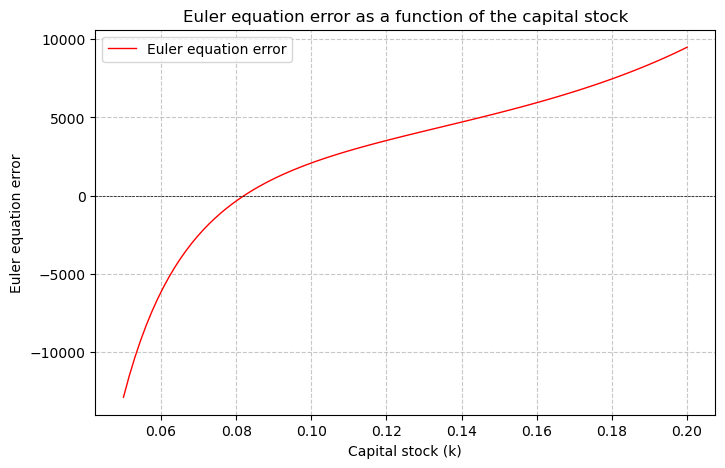

In [4]:
# Import nump for numerical operations
import numpy as np

# Create a grid of capital values, k, on the interval [0.05, 0.2]
k_gird = np.linspace(0.05, 0.2, 100)

# Create an empty array to store the Euler equation error
euler_err_grid = np.empty_like(k_gird)

# Compute the Euler equation error for each value of k assuming k_next = k
euler_err_grid = euler_err(k_gird, k_gird, par)

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Plot the Euler equation error as a function of the capital stock
plt.figure(figsize=(8, 5))
plt.plot(k_gird, euler_err_grid, c="red", lw=1, label="Euler equation error")
plt.axhline(0, c="black", ls="--", lw=0.5)
plt.xlabel("Capital stock (k)")
plt.ylabel("Euler equation error")
plt.title("Euler equation error as a function of the capital stock")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)


### Why is the graph upward sloping?


***
# Part 2
***

In [5]:
# Defina a data class to store the steady state quantities and prices
@dataclass
class SteadyState:
    par: Parameters = None  # Parameters used to compute equilibrium
    c_y: float = None  # Consumption when young
    c_o: float = None  # Consumption when old
    a: float = None  # Savings when young
    s: float = None  # Savings rate when young
    r: float = None  # Interest rate (return on capital)
    w: float = None  # Wage rate
    K: float = None  # Aggregate capital stock
    L: float = None  # Aggregate labor demand
    I: float = None  # Aggregate investment
    Y: float = None  # Aggregate output

In [6]:
def compute_savings_rate(r, par: Parameters):
    """
    Compute the savings rate using the analytical solution
    to the household problem.

    Parameters
    ----------
    r : float
        Return on capital after depreciation (interest rate)
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    s : float
        Savings rate
    """

    s = 1 / (1 + par.beta ** (-1 / par.gamma) * (1 + r) ** (1 - 1 / par.gamma))

    return s

In [7]:
# Import the root_scalar function from scipy.optimize
from scipy.optimize import root_scalar


# Define a function to compute the steady state equilibrium using root finding
def compute_steady_state(par: Parameters):
    """
    Compute the steady-state equilibrium for the OLG model.

    Parameters
    ----------
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    eq : SteadyState
        Steady state equilibrium of the OLG model
    """
    res = root_scalar(
        lambda k: euler_err(k, k, par),  # k_next = k
        bracket=(0.05, 0.2),  # search interval
    )

    if not res.converged:
        print("Equilibrium root-finder did not converge.")

    # Equilibrium capital stock
    K = res.root

    # Create instance of SteadyState with explicit L
    eq = SteadyState(par=par, K=K, L=1)

    # Compute the equilibrium factor prices
    eq.r, eq.w = compute_prices(eq.K / eq.L, par)

    # Investment in steady state
    eq.I = (
        eq.K * par.delta
    )  # Since we assume k_next = k --> I = k_next - (1-delta)k = k(1 - (1 - delta)) = k*delta

    # Equilibrium household decisions
    eq.s = compute_savings_rate(eq.r, par)
    eq.a = eq.s * eq.w
    eq.c_y = eq.w - eq.a
    eq.c_o = (1 + eq.r) * eq.a

    # Compute output (Include L even though it is 1)
    eq.Y = par.z * eq.K**par.alpha * eq.L ** (1 - par.alpha)

    # Aggregate consumption
    C = eq.c_y + eq.c_o

    # Check that goods market clearing holds using : Y = C + I
    assert (
        abs(eq.Y - C - eq.I) < 1.0e-8
    )  # Assert that the difference is less than 1.0e-8

    return eq

In [8]:
# Function to print the steady state equilibrium
def print_steady_state(eq: SteadyState):
    """
    Print equilibrium prices, allocations, and excess demand.

    Parameters
    ----------
    eq : SteadyState
        SteadyState of the OLG model
    """
    print("Steady-state equilibrium:")
    print(f"-------------------------------------------")
    print("  Households:")
    print(f"    Consumption when young (c_y) =  {eq.c_y:.5f}")
    print(f"    Consumption when old (c_o) =    {eq.c_o:.5f}")
    print(f"    Savings (a) =                   {eq.a:.5f}")
    print(f"    Savings rate (s) =              {eq.s:.5f}")
    print(f"-------------------------------------------")
    print("  Firms:")
    print(f"    Capital (K) =                   {eq.K:.5f}")
    print(f"    Labor (L) =                     {eq.L:.5f}")
    print(f"    Output (Y) =                    {eq.Y:.5f}")
    print(f"-------------------------------------------")
    print("  Prices:")
    print(f"    Interest rate (r) =             {eq.r:.5f}")
    print(f"    Wage rate (w) =                 {eq.w:.5f}")
    print(f"-------------------------------------------")
    print("  Market Clearing Conditions:")
    print(f"    Capital market:                 {eq.K - eq.a:.5e}")
    print(
        f"    Goods market:                   {eq.Y - (eq.c_y + eq.c_o) - eq.I :.5e}"
    )  # Which one should we use?
    print(
        f"    Goods market:                  {(eq.c_y + eq.c_o + eq.a) - eq.Y - (1-eq.par.delta) * eq.K:.5e}"
    )  # Which one should we use?
    print(f"-------------------------------------------")

In [10]:
# Compute the steady state equilibrium
eq = compute_steady_state(par)

# Print the steady state equilibrium
print_steady_state(eq)

Steady-state equilibrium:
-------------------------------------------
  Households:
    Consumption when young (c_y) =  0.17812
    Consumption when old (c_o) =    0.15918
    Savings (a) =                   0.08206
    Savings rate (s) =              0.31541
-------------------------------------------
  Firms:
    Capital (K) =                   0.08206
    Labor (L) =                     1.00000
    Output (Y) =                    0.40653
-------------------------------------------
  Prices:
    Interest rate (r) =             0.93963
    Wage rate (w) =                 0.26018
-------------------------------------------
  Market Clearing Conditions:
    Capital market:                 2.49800e-15
    Goods market:                   2.30371e-15
    Goods market:                  -4.77569e-15
-------------------------------------------


***
# Part 3
***

In [11]:
# Define a data class to store the simulated time series
@dataclass
class Simulation:
    """
    Stores time series data for transition dynamics.
    """

    c_y: np.ndarray = None  # Time series for consumption when young
    c_o: np.ndarray = None  # Time series for consumption when old
    a: np.ndarray = None  # Time series for savings when young
    s: np.ndarray = None  # Time series for savings rate when young
    r: np.ndarray = None  # Time series for interest rate (return on capital)
    w: np.ndarray = None  # Time series for wages
    K: np.ndarray = None  # Time series for aggregate capital stock
    Y: np.ndarray = None  # Time series for aggregate output
    z: np.ndarray = None  # Time series for TFP

In [12]:
# Define a function to initialize the simulation and allocate arrays for time series
def initialize_sim(T, eq: SteadyState = None):
    """
    Initialize simulation instance (allocate arrays for time series).

    Parameters
    ----------
    T : int
        Number of periods to simulate
    eq : SteadyState, optional
        Steady-state equilibrium to use for initial period
    """
    # Initialize simulation instance
    sim = Simulation()

    # Initialize time series arrays
    sim.c_y = np.zeros(T + 1)
    sim.c_o = np.zeros(T + 1)
    sim.a = np.zeros(T + 1)
    sim.s = np.zeros(T + 1)
    sim.r = np.zeros(T + 1)
    sim.w = np.zeros(T + 1)
    sim.K = np.zeros(T + 1)
    sim.Y = np.zeros(T + 1)
    sim.z = np.zeros(T + 1)

    # If eq is provided, set initial values to steady state
    if eq is not None:
        sim.c_y[0] = eq.c_y
        sim.c_o[0] = eq.c_o
        sim.a[0] = eq.a
        sim.s[0] = eq.s
        sim.r[0] = eq.r
        sim.w[0] = eq.w
        sim.K[0] = eq.K
        sim.Y[0] = eq.Y
        sim.z[0] = eq.par.z

    return sim

In [ ]:
# Define a function to simulate the transition dynamics of the OLG model
def simulate_olg(K1, T, eq: SteadyState, par: Parameters):
    """
    Simulate the transition dynamics of the OLG model starting from steady state
    when a shock to capital realizes in period 1.

    Parameters
    ----------
    K1 : float
        Initial capital stock in period 1.
    T : int
        Number of periods to simulate.
    eq : SteadyState
        Initial steady-state equilibrium of the OLG model before the shock.

    Returns
    -------
    sim : Simulation
        Simulation object containing the time series for each variable
    """
    # Retrieve parameter object attached to steady-state equilibrium
    par = eq.par

    # Initialize simulation
    sim = initialize_sim(T, eq)

    # Set the capital stock in period 1 following the shock
    sim.K[1] = K1

    # Set the TFP to initial value for all periods
    sim.z[:] = par.z

    # Iterate over time periods
    for t in range(1, T + 1):
        # Update capital stock with current period's value
        sim.r[t], sim.w[t] = compute_prices(sim.K[t], par)

        if t < T:
            # Solve for next-period capital using root-finding on the Euler equation
            res = root_scalar(
                lambda k_next: euler_err(k_next, sim.K[t], par), bracket=(0.05, 0.2)
            )

            if not res.converged:
                raise ValueError(f"Root-finding did not converge at t = {t}")

            # Store next period's capital stock
            sim.K[t + 1] = res.root

        # Compute household decisions
        sim.s[t] = compute_savings_rate(sim.r[t], par)
        sim.a[t] = sim.s[t] * sim.w[t]
        sim.c_y[t] = sim.w[t] - sim.a[t]  # a = s*w
        sim.c_o[t] = (1 + sim.r[t]) * sim.a[t - 1]

        # Update aggregate output
        sim.Y[t] = sim.z[t] * sim.K[t] ** par.alpha * 1 ** (1 - par.alpha)  # L = 1

        # Verify goods market clearing holds
        demand = sim.c_y[t] + sim.c_o[t] + sim.a[t]
        supply = sim.Y[t] + (1 - par.delta) * sim.K[t]
        # assert abs(demand - supply) < 1.0e-8

    return sim

In [18]:
# Shock: Assuming the capital falls to half of steady state in period 1
K1 = eq.K / 2

# Simulate the transition dynamics for T = 20 periods --> [0, 1, 2, ..., 20] meaning 21 values
sim = simulate_olg(K1, T=20, eq=eq, par=par)

AssertionError: 

In [15]:
from matplotlib.ticker import PercentFormatter


def plot_simulation(eq, sim, eq_new=None, deviations=True, filename=None):
    """
    Plot the simulated time series for Y, K, w, r, s in a 3x2 grid.
    The first three (Y, K, w) are shown as percent deviations from their
    initial steady-state values if deviations=True. The last two (r, s)
    are shown in levels.

    Parameters
    ----------
    eq : SteadyState
        Initial steady-state equilibrium. Used for reference lines
        and to compute deviations if 'deviations=True'.
    sim : Simulation
        The simulation object containing time series data.
    eq_new : SteadyState, optional
        If provided, also plot a dashed horizontal line for the
        new steady-state level in each subplot.
    deviations : bool, default True
        If True, plot Y, K, w as % deviations from the old steady state;
        if False, plot them in levels.
    filename : str, optional
        If provided, the figure is saved to this file.
    """
    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True)

    # Turn off the last subplot
    axes[2, 1].axis("off")

    # Keyword arguments for the main time-series plots
    kwargs_line = {
        "marker": "o" if len(sim.Y) < 30 else None,
        "markersize": 4,
        "color": "red",
        "label": "Simulation",
    }

    # Keyword arguments for the old (initial) steady-state lines
    kwargs_init = {
        "color": "black",
        "linewidth": 0.8,
        "linestyle": "--",
        "label": "Steady State" if eq_new is not None else "Initial SS",
    }

    # Keyword arguments for the new steady-state lines
    kwargs_new = {
        "color": "blue",
        "linewidth": 0.8,
        "linestyle": "--",
        "label": "New SS",
    }

    # Define a function to compute % deviations
    def pct_dev(series, ss_value):
        if deviations:
            return 100 * (series / ss_value - 1)
        else:
            return series

    # ------------------------------------------------
    # 1) Y_t: % dev if deviations = True, else level
    # ------------------------------------------------
    ax = axes[0, 0]
    yvals = pct_dev(sim.Y, eq.Y)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.Y
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.Y
        if deviations:
            ref_line_new = 100 * (eq_new.Y / eq.Y - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$Y_t$")
    ax.set_ylabel("Deviations from initial SS" if deviations else "Level")

    # ------------------------------------------------
    # 2) K_t: % dev if deviations=True, else level
    # ------------------------------------------------
    ax = axes[0, 1]
    yvals = pct_dev(sim.K, eq.K)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.K
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.K
        if deviations:
            ref_line_new = 100 * (eq_new.K / eq.K - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$K_t$")

    # ------------------------------------------------
    # 3) w_t: % dev if deviations=True, else level
    # ------------------------------------------------
    ax = axes[1, 0]
    yvals = pct_dev(sim.w, eq.w)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.w
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.w
        if deviations:
            ref_line_new = 100 * (eq_new.w / eq.w - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$w_t$")
    ax.set_ylabel("Deviations from initial SS" if deviations else "Level")

    # ------------------------------------------------
    # 4) r_t (always in levels)
    # ------------------------------------------------
    ax = axes[1, 1]
    ax.plot(sim.r, **kwargs_line)
    ax.axhline(eq.r, **kwargs_init)
    if eq_new is not None:
        ax.axhline(eq_new.r, **kwargs_new)
    ax.set_title(r"$r_t$ (levels)")
    ax.set_xlabel("Period")
    ax.tick_params(axis="x", labelbottom=True)

    # ------------------------------------------------
    # 5) s_t (always in levels)
    # ------------------------------------------------
    ax = axes[2, 0]
    ax.plot(sim.s, **kwargs_line)
    ax.axhline(eq.s, **kwargs_init)
    if eq_new is not None:
        ax.axhline(eq_new.s, **kwargs_new)
    ax.set_title(r"$s_t = \frac{a_t}{w_t}$ (levels)")
    ax.set_xlabel("Period")
    ax.set_ylabel("Level")

    # Apply settings common to all axes
    if deviations:
        # Format the first three subplots as percent
        for row, col in [(0, 0), (0, 1), (1, 0)]:
            axes[row, col].yaxis.set_major_formatter(PercentFormatter(decimals=0))

    axes[0, 0].legend(loc="lower right")
    fig.tight_layout()

    # Optional save
    if filename:
        plt.savefig(filename)

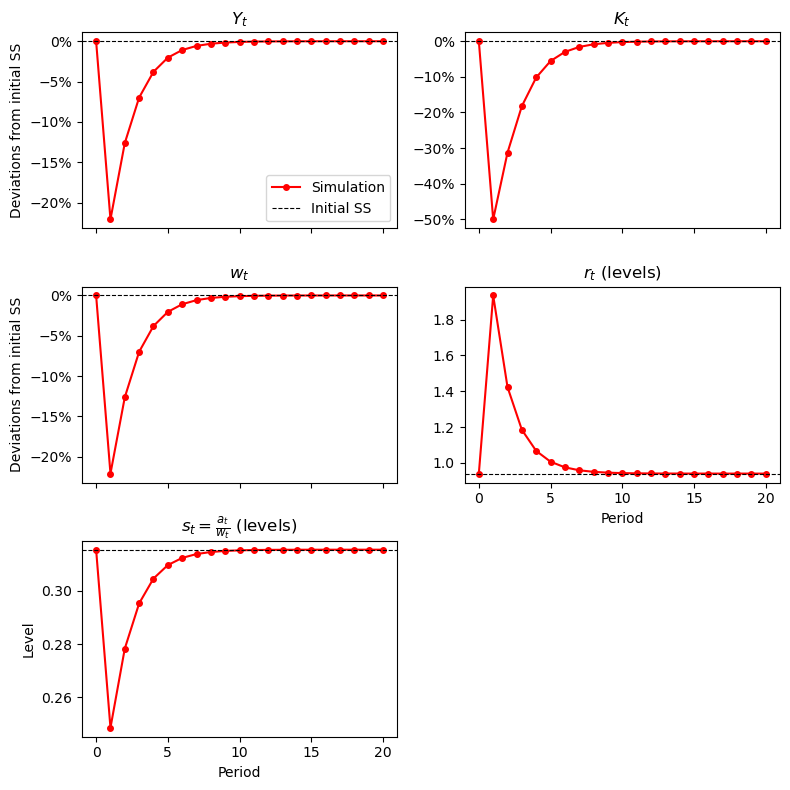

In [16]:
# Plot the transition dynamics of the OLG model
plot_simulation(eq, sim)  # No new steady state

***
# Part 4
***

In [ ]:
par = Parameters(tau=0.1)
eq_pension = compute_steady_state(par)
print_steady_state(eq_pension)
sim_olg_pension = simulate_olg(eq.K, T, eq, par)
plot_simulation(eq, sim_olg_pension, eq_pension)